In [1]:
aud1='/Users/zombie/Downloads/datadrive/theWitcher/wavs/audio126.wav'
aud2='/Users/zombie/Downloads/datadrive/theWitcher/revWavs/audio126.wav'
wav='/Users/zombie/Downloads/datadrive/ljspeech/wavs/'
rev='/Users/zombie/Downloads/datadrive/ljspeech/revWavs/'

In [2]:
import librosa, os
import random
from os import listdir
from glob import glob
import numpy as np
from librosa import display
from itertools import cycle, islice, chain
import torch
from os import listdir
import torchvision.transforms as transforms
from matplotlib import cm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, IterableDataset, DataLoader
%matplotlib inline

In [7]:
from dataset import TrainDataset

In [10]:
dset=TrainDataset(wav, rev, 16000, 1024, 32, 'hamming', True)
loader=DataLoader(dset, batch_size=32)
i=0
maxs=[]
maxis=[]
for batch in loader:
    print('yes {}'.format(i), end="\r")
    maxs.append(batch[0].max())
    maxis.append(batch[1].max())
    i+=1
    if i==3:
        break
#     print(batch[0].max())
    

In [15]:
batch[0].shape

torch.Size([32, 1, 512, 512])

In [13]:
temp=batch[0][1][0]
temp1=batch[1][1][0]

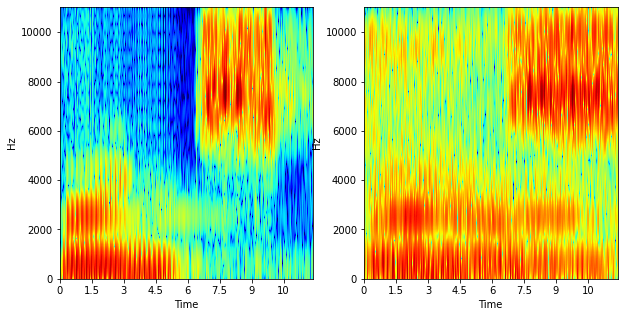

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.power_to_db(temp.numpy()), cmap=cm.jet, y_axis="hz", x_axis="time")
plt.subplot(1,2,2)
librosa.display.specshow(librosa.power_to_db(temp1.numpy()), cmap=cm.jet,y_axis="hz", x_axis="time")